In [1]:
import matplotlib.pyplot as plt

import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import axes3d

from PIL import Image
import heapq
import os
import sys
import cv2
import ransac

ImportError: No module named 'ransac'

210×297 мм
## 2. Camera class

In [22]:
# Class for representing pin-hole cameras. """
class Camera(object):

# Initialize P = K[R|t] camera model.
    def __init__(self,P):
        self.P = P
        self.K = None # calibration matrix
        self.R = None # rotation
        self.t = None # translation
        self.c = None # camera center4

# Project points in X (4*n array) and normalize coordinates.
    def project(self,X):
        x = np.dot(self.P,X)

        for i in range(3):
            x[i] /= x[2]
        return x
    
# Creates a 3D rotation matrix for rotation around the axis of the vector a.
    def rotation_matrix(a):
        R = np.eye(4)

        R[:3,:3] = linalg.expm([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])

        return R

# Factorize the camera matrix into K,R,t as P = K[R|t]. """
    def factor(self):
        # factor first 3*3 part
        K,R = linalg.rq(self.P[:,:3])

        # make diagonal of K positive
        T = np.diag(sign(diag(K)))

        if linalg.det(T) < 0:
            T[1,1] *= -1

        self.K = np.dot(K,T)
        self.R = np.dot(T,R) # T is its own inverse
        self.t = np.dot(linalg.inv(self.K),self.P[:,3])

        return self.K, self.R, self.t

# Compute and return the camera center.
    def center(self):
        if self.c is not None:
            return self.c
        else:
# compute c by factoring
            self.factor()
            self.c = -np.dot(self.R.T,self.t)
        return self.c
# 
def my_calibration(sz):
    row,col,clr = sz
    fx = 5170*col/4608
    fy = 5220*row/3456
    K = np.diag([fx,fy,1])
    K[0,2] = 0.5*col
    K[1,2] = 0.5*row
    return K

## 3. SIFT Module

In [15]:
# Process an image and save the results in a file.
def process_image(imagename, resultname, params="--edge-thresh=10 --peak-thresh=5"):
    if imagename[-3:] != 'pgm':
# create a pgm file
        im = Image.open(imagename).convert('L')
        im.save('tmp.pgm')
    
    imagename = 'tmp.pgm'
    cmmd = str("C:/Users/User/Desktop/vlfeat-0.9.20-bin/vlfeat-0.9.20/bin/win64/sift " + imagename + " --output=" + resultname + " " + params)
    os.system(cmmd)
    
    print 'processed ' + imagename + ' to ' + resultname

# Read feature properties and return in matrix form.
def read_features_from_file(filename):
    f = np.loadtxt(filename)
    
    return f[:,:4],f[:,4:] # feature locations, descriptors

# Save feature location and descriptor to file.
def write_features_to_file(filename, locs, desc):
    np.savetxt(filename, hstack((locs, desc)))
    
# Show image with features. input: im (image as array),locs (row, col, scale, orientation of each feature).
def plot_features(im, locs, circle=False):
    def draw_circle(c,r):
        t = arange(0, 1.01, .01) * 2 * pi

        x = r * cos(t) + c[0]
        y = r * sin(t) + c[1]
        plt.plot(x, y, 'b', linewidth=2)
        plt.imshow(im)

    if circle:
        for p in locs:
            draw_circle(p[:2], p[2])
    else:
        plt.plot(locs[:,0], locs[:,1], 'ob')
    plt.axis('off')
    
# For each descriptor in the first image,
# select its match in the second image.
# input: desc1 (descriptors for the first image),
# desc2 (same for second image).
def match(desc1, desc2):
    
    desc1 = np.array([d / linalg.norm(d) for d in desc1])
    desc2 = np.array([d / linalg.norm(d) for d in desc2])
    
    dist_ratio = 0.6
    desc1_size = desc1.shape

    matchscores = np.zeros((desc1_size[0], 1), 'int')

    desc2t = desc2.T # precompute matrix transpose

    for i in range(desc1_size[0]):
        dotprods = np.dot(desc1[i,:], desc2t) # vector of dot products
        dotprods = 0.9999 * dotprods

        # inverse cosine and sort, return index for features in second image
        indx = np.argsort(np.arccos(dotprods))
        # check if nearest neighbor has angle less than dist_ratio times 2nd
        if np.arccos(dotprods)[indx[0]] < dist_ratio * np.arccos(dotprods)[indx[1]]:
            matchscores[i] = int(indx[0])
    return matchscores

# Two-sided symmetric version of match().
def match_twosided(desc1,desc2):
    
    matches_12 = match(desc1, desc2)
    matches_21 = match(desc2, desc1)
    ndx_12 = matches_12.nonzero()[0]
    
    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[int(matches_12[n])] != n:
            matches_12[n] = 0

    return matches_12

## 4. RANSAC module

In [25]:
class RansacModel(object):

    """ Class for fundmental matrix fit with ransac.py from
    http://www.scipy.org/Cookbook/RANSAC"""
    def __init__(self, debug=False):
        self.debug = debug

    def fit(self, data):
        """ Estimate fundamental matrix using eight
        selected correspondences. """
        # transpose and split data into the two point sets
        data = data.T
        x1 = data[:3,:8]
        x2 = data[3:,:8]
        # estimate fundamental matrix and return
        F =  compute_fundamental_normalized(x1, x2)
        return F

    def get_error(self,data,F):
        """ Compute x^T F x for all correspondences,
        return error for each transformed point. """
        # transpose and split data into the two point
        data = data.T
        x1 = data[:3]
        x2 = data[3:]
        # Sampson distance as error measure
        Fx1 = np.dot(F, x1)
        Fx2 = np.dot(F, x2)
        denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
        err = (np.diag(np.dot(x1.T, np.dot(F, x2))))**2 / denom
        
        # return error per point
        return err
    
def compute_fundamental_normalized(x1, x2):
    """ Computes the fundamental matrix from corresponding points
    (x1,x2 3*n arrays) using the normalized 8 point algorithm. """

    n = x1.shape[1]

    if x2.shape[1] != n:
        raise ValueError("Number of points don’t match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2], axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1, 0, -S1 * mean_1[0]], [0, S1, -S1 * mean_1[1]], [0, 0, 1]])
    x1 = np.dot(T1, x1)
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2], axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2, 0, -S2 * mean_2[0]], [0, S2, -S2 * mean_2[1]], [0, 0, 1]])
    x2 = np.dot(T2, x2)
    # compute F with the normalized coordinates
    F = compute_fundamental(x1, x2)
    # reverse normalization
    F = np.dot(T1.T, np.dot(F, T2))
    return F / F[2,2]

def F_from_ransac(x1, x2, model, maxiter=5000, match_theshold=1e-6):
    """ Robust estimation of a fundamental matrix F from point
    correspondences using RANSAC (ransac.py from
    http://www.scipy.org/Cookbook/RANSAC).
    input: x1,x2 (3*n arrays) points in hom. coordinates. """
    data = np.vstack((x1, x2))
    # compute F and return with inlier index
    F, ransac_data = ransac.ransac(data.T, model, 8, maxiter, match_theshold, 20, return_all=True)

    return F, ransac_data['inliers']

def compute_fundamental(x1,x2):
    """ Computes the fundamental matrix from corresponding points
    (x1,x2 3*n arrays) using the normalized 8 point algorithm.
    each row is constructed as
    [x’*x, x’*y, x’, y’*x, y’*y, y’, x, y, 1] """
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don’t match.")

    # build matrix for equations
    A = np.zeros((n, 9))

    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
            x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
            x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i]]

    # compute linear least square solution
    U,S,V = linalg.svd(A)
    F = V[-1].reshape(3, 3)
    # constrain F
    # make rank 2 by zeroing out last singular value
    U, S, V = linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    return F

def compute_epipole(F):
    """ Computes the (right) epipole from a
    fundamental matrix F.
    (Use with F.T for left epipole.) """
    # return null space of F (Fx=0)
    U, S, V = linalg.svd(F)
    e = V[-1]
    return e / e[2]

def plot_epipolar_line(im,F,x,epipole=None,show_epipole=True):
    """ Plot the epipole and epipolar line F*x=0
    in an image. F is the fundamental matrix
    and x a point in the other image."""
    m,n = im.shape[:2]
    line = np.dot(F, x)
    # epipolar line parameter and values
    t = np.linspace(0, n, 100)
    lt = np.array([(line[2]+line[0]*tt)/(-line[1]) for tt in t])
    # take only line points inside the image
    ndx = (lt >= 0) & (lt < m)
    plt.plot(t[ndx], lt[ndx], linewidth=2)
    if show_epipole:
        if epipole is None:
            epipole = compute_epipole(F)
    plt.plot(epipole[0] / epipole[2], epipole[1] / epipole[2], 'r*')

def triangulate_point(x1,x2,P1,P2):
    """ Point pair triangulation from
    least squares solution. """
    M = np.zeros((6, 6))
    M[:3,:4] = P1
    M[3:,:4] = P2
    M[:3,4] = -x1
    M[3:,5] = -x2
    U, S, V = linalg.svd(M)
    X = V[-1,:4]
    return X / X[3]

def triangulate(x1,x2,P1,P2):
    """ Two-view triangulation of points in
    x1,x2 (3*n homog. coordinates). """
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don’t match.")
    X = [triangulate_point(x1[:,i],x2[:,i],P1,P2) for i in range(n)]
    return np.array(X).T

def compute_P(x, X):
    """ Compute camera matrix from pairs of
    2D-3D correspondences (in homog. coordinates). """
    n = x.shape[1]
    if X.shape[1] != n:
        raise ValueError("Number of points don’t match.")
    # create matrix for DLT solution
    M = np.zeros((3*n, 12+n))
    for i in range(n):
        M[3*i,0:4] = X[:,i]
        M[3*i+1,4:8] = X[:,i]
        M[3*i+2,8:12] = X[:,i]
        M[3*i:3*i+3,i+12] = -x[:,i]
    U,S,V = linalg.svd(M)
    return V[-1,:12].reshape((3,4))

def compute_P_from_fundamental(F):
    """ Computes the second camera matrix (assuming P1 = [I 0])
    from a fundamental matrix. """
    e = compute_epipole(F.T) # left epipole
    Te = skew(e)
    return np.vstack((np.dot(Te, F.T).T, e)).T

def skew(a):
    """ Skew matrix A such that a x v = Av for any v. """
    return np.array([[0, -a[2], a[1]], [a[2], 0, -a[0]], [-a[1], a[0], 0]])

def compute_P_from_essential(E):
    """ Computes the second camera matrix (assuming P1 = [I 0])
    from an essential matrix. Output is a list of four
    possible camera matrices. """
    # make sure E is rank 2
    U, S, V = linalg.svd(E)
    if linalg.det(np.dot(U, V)) < 0:
        V = -V
    E = np.dot(U, np.dot(np.diag([1, 1, 0]), V))
    # create matrices (Hartley p 258)
    Z = skew([0, 0, -1])
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    # return all four solutions
    P2 = [np.vstack((np.dot(U, np.dot(W, V)).T, U[:,2])).T,
        np.vstack((np.dot(U, np.dot(W, V)).T, -U[:,2])).T,
        np.vstack((np.dot(U, np.dot(W.T, V)).T, U[:,2])).T,
        np.vstack((np.dot(U, np.dot(W.T, V)).T, -U[:,2])).T]
    return P2

## 5. Homography

In [5]:
def normalize(points):
    """ Normalize a collection of points in
    homogeneous coordinates so that last row = 1. """
    for row in points:
        row /= points[-1]
    return points

def make_homog(points):
    """ Convert a set of points (dim*n array) to
    homogeneous coordinates. """
    return np.vstack((points, np.ones((1, points.shape[1]))))

def H_from_points(fp, tp):
    """ Find homography H, such that fp is mapped to tp
    using the linear DLT method. Points are conditioned
    automatically. """
    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')
    # condition points (important for numerical reasons)
    # --from points--
    m = np.mean(fp[:2], axis=1)
    maxstd = np.max(std(fp[:2], axis=1)) + 1e-9
    C1 = np.diag([1/maxstd, 1/maxstd, 1])
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp = np.dot(C1,fp)
    # --to points--
    m = np.mean(tp[:2], axis=1)
    maxstd = np.max(np.std(tp[:2], axis=1)) + 1e-9
    C2 = np.diag([1/maxstd, 1/maxstd, 1])
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp = np.dot(C2,tp)
    # create matrix for linear method, 2 rows for each correspondence pair
    nbr_correspondences = fp.shape[1]
    A = np.zeros((2*nbr_correspondences,9))
    for i in range(nbr_correspondences):
        A[2*i] = [-fp[0][i],-fp[1][i],-1,0,0,0,
            tp[0][i]*fp[0][i],tp[0][i]*fp[1][i],tp[0][i]]
        A[2*i+1] = [0,0,0,-fp[0][i],-fp[1][i],-1,
            tp[1][i]*fp[0][i],tp[1][i]*fp[1][i],tp[1][i]]
    U,S,V = linalg.svd(A)
    H = V[8].reshape((3,3))
    # decondition
    H = np.dot(linalg.inv(C2),np.dot(H,C1))
    # normalize and return
    return H / H[2,2]

def Haffine_from_points(fp,tp):
    """ Find H, affine transformation, such that
    tp is affine transf of fp. """
    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')
    # condition points
    # --from points--
    m = np.mean(fp[:2], axis=1)
    maxstd = np.max(np.std(fp[:2], axis=1)) + 1e-9
    C1 = np.diag([1/maxstd, 1/maxstd, 1])
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp_cond = np.dot(C1,fp)
    # --to points--
    m = np.mean(tp[:2], axis=1)
    C2 = C1.copy() #must use same scaling for both point sets
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp_cond = np.dot(C2,tp)
    # conditioned points have mean zero, so translation is zero
    A =  np.concatenate((fp_cond[:2],tp_cond[:2]), axis=0)
    U,S,V = linalg.svd(A.T)
    # create B and C matrices as Hartley-Zisserman (2:nd ed) p 130.
    tmp = V[:2].T
    B = tmp[:2]
    C = tmp[2:4]
    tmp2 = np.concatenate((np.dot(C,linalg.pinv(B)),np.zeros((2,1))), axis=1)
    H = np.vstack((tmp2,[0,0,1]))
    # decondition
    H = np.dot(linalg.inv(C2),np.dot(H,C1))
    return H / H[2,2]

## 6. Demo

In [17]:
im1 = np.array(Image.open('pictures/samples/pict0.jpg'))

im2 = np.array(Image.open('pictures/samples/pict1.jpg'))

In [ ]:
# load images and compute features
process_image('alcatraz1.jpg','0.txt')

process_image('alcatraz2.jpg','1.txt')

In [10]:
l1,d1 = read_features_from_file('pictures/sift/0.txt')
l2,d2 = read_features_from_file('pictures/sift/1.txt')

In [26]:
# match features

matches = match_twosided(d1,d2)

ndx = matches.nonzero()[0]

# make homogeneous and normalize with inv(K)

x1 = make_homog(l1[ndx,:2].T)

ndx2 = [int(matches[i]) for i in ndx]

x2 = make_homog(l2[ndx2,:2].T)

if im1.shape == im2.shape:
    K = my_calibration(im1.shape)
else:
    raise Exception("Dimentions don't match")

x1n = np.dot(linalg.inv(K),x1)

x2n = np.dot(linalg.inv(K),x2)

# estimate E with RANSAC

model = RansacModel()

E, inliers = F_from_ransac(x1n, x2n, model)

# compute camera matrices (P2 will be list of four solutions)

P1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])

P2 = compute_P_from_essential(E)

In [27]:
# pick the solution with points in front of cameras
ind = 0
maxres = 0
for i in range(4):
    # triangulate inliers and compute depth for each camera
    X = triangulate(x1n[:,inliers],x2n[:,inliers],P1,P2[i])
    d1 = np.dot(P1,X)[2]
    d2 = np.dot(P2[i],X)[2]
    if np.sum(d1>0) + np.sum(d2>0) > maxres:
        maxres = sum(d1>0)+sum(d2>0)
        ind = i
        infront = (d1>0) & (d2>0)

# triangulate inliers and remove points not in front of both cameras
X = triangulate(x1n[:,inliers],x2n[:,inliers],P1,P2[ind])
X = X[:,infront]

In [30]:
fig = plt.figure()

ax = fig.gca(projection='3d')

ax.plot(-X[0],X[1],X[2],'k.')

plt.axis('on')

(-1.5, 2.0, -0.40000000000000002, 0.30000000000000004)

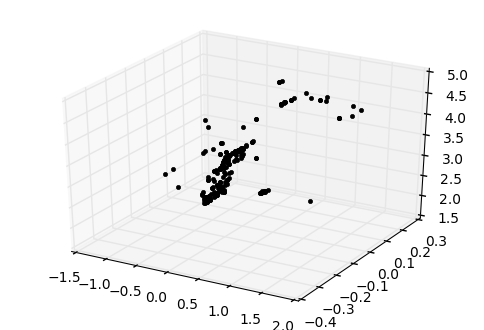

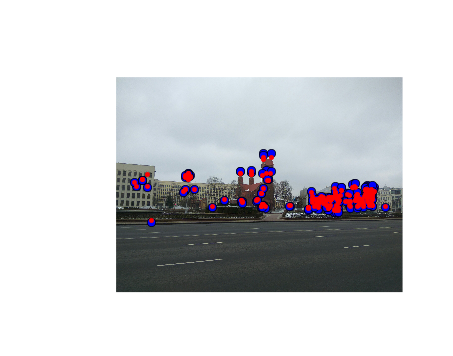

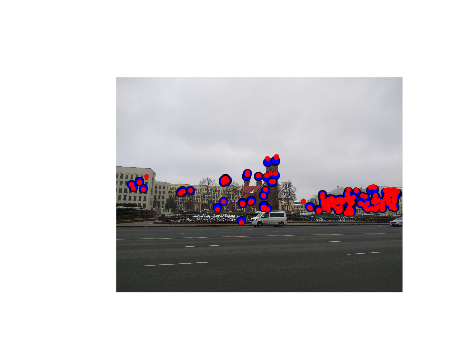

In [31]:
# project 3D points
cam1 = Camera(P1)
cam2 = Camera(P2[ind])
x1p = cam1.project(X)
x2p = cam2.project(X)
# reverse K normalization
x1p = np.dot(K,x1p)
x2p = np.dot(K,x2p)
plt.figure()
plt.imshow(im1)
plt.gray()
plt.plot(x1p[0],x1p[1],'o')
plt.plot(x1[0],x1[1],'r.')
plt.axis('off')
plt.figure()
plt.imshow(im2)
plt.gray()
plt.plot(x2p[0],x2p[1],'o')
plt.plot(x2[0],x2[1],'r.')
plt.axis('off')
plt.show()